In [610]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pyproj
import random
import uuid
# Pyproj Correction
pyproj.datadir.set_data_dir('/Users/shai/anaconda3/envs/geo_env/share/proj')

In [611]:
pd.options.display.max_columns=100

## Parameters

In [612]:
arnonaSqM = 5.43
rentPPM = 70
buyPPM = 20000
owners=0.65


In [547]:
jewishPopDemo2019 = pd.read_excel('israel_population_jewish_lamas_groups_of_10_2019.xlsx')
jewishPopDemo2019.reset_index(inplace=True,drop=True)
jewishPopDemo2019.drop([0,1],inplace=True)
tot = jewishPopDemo2019['Total'].sum()
jewishPopDemo2019['ratio'] = jewishPopDemo2019['Total']/tot
mid = [ 10*i+25 for i in range(8)]
jewishPopDemo2019['middle'] = mid
ageDist = [0.2, 0.2, 0.18, 0.15, 0.14, 0.08, 0.04, 0.01]
ageMiddle = jewishPopDemo2019['middle'].values.tolist()

https://www.cbs.gov.il/he/Pages/search/TableMaps.aspx?CbsSubject=אוכלוסייה

<AxesSubplot:xlabel='Age Group 10'>

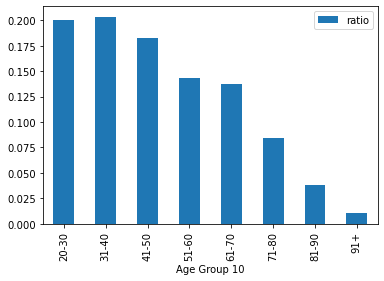

In [548]:
jewishPopDemo2019.plot.bar(x='Age Group 10',y='ratio')

In [549]:
jewishPopDemo2019['middlexDist'] = jewishPopDemo2019['middle'] * jewishPopDemo2019['ratio']

In [550]:
jewishPopDemo2019['middlexDist'].sum()

47.736349013718424

In [551]:
bldgs = pd.read_excel('BuildingInSimulationAndStatsApril7.xlsx') #Bldgs Data
originalAgents = pd.read_excel('OrigianlAgentsApril7_2021.xlsx') #original Agents - can be gerenated many times for sensitivity analysis
newApartments = pd.read_excel('newApartmentsDataSetApril_7.xlsx') # new apartments

In [552]:
newApartments.drop(columns='Unnamed: 0',inplace=True)

## Function

In [553]:
def mortgageCal(houseValue, downPaymentPercent_range=(0.25, 0.5), years_pay=25, intrest=3.46):
    '''
        houseValue - House Value
        downPaymentPercent_range=(0.25, 0.5)
        years_pay=25
        intrest=3.46
    '''
    # Mortage Calculator
    # houseValue for example 2 Milion Shekels
    # downPayment percent the the percent that the Agent can pay of the house 25% is 500000 NIS
    # year_pay typical 25 years
    # interset typical 3.46
    dppr = downPaymentPercent_range
    downPaymentPercent = random.uniform(dppr[0], dppr[1])
    downPayment = houseValue * downPaymentPercent  # calculating the downPayment
    P = houseValue-downPayment  # Mortrage requested
    i_m = ((intrest)/100.0)/12.0  # interset percent divided by 12 months
    n_m = years_pay*12  # convert years to months
    M = (P*i_m*np.power((1+i_m), n_m))/(np.power((1+i_m), n_m)-1)
    return M

## Move all agents to new appartments add to them the itertion number this will be a template for Agents Time Series

In [554]:
AgentsTimeSeries = originalAgents.copy()
AgentsTimeSeries.drop(columns=['Unnamed: 0'],inplace=True)

In [555]:
AgentsTimeSeries['prjectType'] = 0
AgentsTimeSeries['tic'] = 0
AgentsTimeSeries['status'] = 'stay'
AgentsTimeSeries['noDiscount'] = AgentsTimeSeries['noDiscount'].fillna(0)
AgentsTimeSeriesOriginal = AgentsTimeSeries.copy()

In [556]:
bldgs.sort_values(by='OrderA',inplace=True)

In [557]:
for tic in bldgs['OrderA'].values:

    currentProject = bldgs.query('OrderA=='+str(tic))['ProjNumber'].values[0]
    projectType = bldgs.query('OrderA=='+str(tic))['ProjType'].values[0].astype(int)
    newApartmentsSlice = newApartments.query('ProjNumber=="'+currentProject+'"').copy()
    newApartmentsSlice.reset_index(inplace=True,drop=True)
    CurrentAgents = AgentsTimeSeriesOriginal.query('ProjNumber=="'+currentProject+'"').copy().reset_index(drop=True)
    CurrentAgents.drop(columns=['bldCode','doorIndex','bldCodeDoorIndex','ProjNumber','aprtmentSize','tic','prjectType'],inplace=True)
    CurrentAgentsNewApartments = pd.concat([newApartmentsSlice,CurrentAgents],axis=1).reset_index(drop=True)
    CurrentAgentsNewApartments['tic'] = tic
    AgentsTimeSeries = pd.concat([AgentsTimeSeries,CurrentAgentsNewApartments]).reset_index(drop=True)
    #AgentsTimeSeries.reset_i

In [558]:
bldg_reference = gpd.read_file('Json/simulationBldgs_Process_march1_1729.geojson')
bldAfter = bldg_reference[bldg_reference['status']=='Building after']

## Droped Duplicates In Colab !!!

In [559]:
bldAfter.query('bld_addres=="210_30_210_32_rr"')

,fid,Area,floors,height,bld_num,bld_addres,hebrew_adr,project_nu,units,project_na,project_ty,status,East,North,East_wgs84,North_wgs8,active,start_date,end_date,geometry
104,235,0.0,30.0,93.0,0.0,210_30_210_32_rr,"הרצל 30 והרצל 32, בת ים",502-0196659,208.0,None,3.0,Building after,175834.625565,659447.829993,34.742741,32.027446,1,2025-09-13,2100-01-01,"POLYGON ((175855.785 659461.417, 175857.643 65..."
116,247,0.0,8.0,50.0,0.0,210_30_210_32_rr,"הרצל 30 והרצל 32, בת ים",502-0196659,0.0,None,3.0,Building after,175776.801757,659449.599257,34.742128,32.027460,1,2025-09-13,2100-01-01,"POLYGON ((175795.175 659462.771, 175781.589 65..."
117,248,0.0,6.0,41.0,0.0,210_30_210_32_rr,"הרצל 30 והרצל 32, בת ים",502-0196659,0.0,None,3.0,Building after,175808.326367,659442.232639,34.742462,32.027395,1,2025-09-13,2100-01-01,"POLYGON ((175811.578 659458.497, 175812.905 65..."
118,249,0.0,6.0,41.0,0.0,210_30_210_32_rr,"הרצל 30 והרצל 32, בת ים",502-0196659,0.0,None,3.0,Building after,175823.598805,659408.555323,34.742626,32.027092,1,2025-09-13,2100-01-01,"POLYGON ((175857.909 659420.069, 175832.994 65..."


In [560]:
bldAfter = bldAfter.drop([116,117,118])

In [561]:
bldAfter.reset_index(drop=True,inplace=True)

In [562]:
bld_floor = bldAfter[['bld_addres','floors']]

In [563]:
def getBldHeight(bldCode):
    Floors = bld_floor.query(f"bld_addres=='{bldCode}'")['floors']
    return Floors.values[0].astype(int)

# add floors from GIS :)

In [564]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0").index,"Floors"] \
= AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0").index,"bldCode"]\
.apply(lambda x:bld_floor.query(f"bld_addres=='{x}'")['floors'].values[0].astype(int))

In [565]:
newBldgMaintenance = pd.DataFrame({'floor_min':[0,5,9,13],'floor_max':[4,8,12,100],'cost':[250,320,400,450]})

In [566]:
newBldgMaintenance

,floor_min,floor_max,cost
0,0,4,250
1,5,8,320
2,9,12,400
3,13,100,450


In [567]:
def getConstFromFloor(floor):
    floorInt = str(int(floor))
    cost = newBldgMaintenance.query(f"floor_min<={floorInt} and floor_max>={floorInt}")['cost']
    return cost.values[0]

In [568]:
getConstFromFloor(7)

320

In [569]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0").index,'MainCost'] = AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0").index,'Floors'].apply(getConstFromFloor)

In [570]:
AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'cityTax'] =  AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'aprtmentSize']*arnonaSqM

In [571]:
AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'CostForStaying'] = AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'cityTax']+AgentsTimeSeries.loc[(AgentsTimeSeries['tic']>0),'MainCost']

## Not Null do this

In [572]:
con = ((AgentsTimeSeries['income'].notna())) & (AgentsTimeSeries['tic']>0)

In [573]:
AgentsTimeSeries.loc[con,'ratioCostForStaying'] = AgentsTimeSeries.loc[con,'CostForStaying']/AgentsTimeSeries.loc[con,'income']

In [574]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0 and rent==1.0").index,'status'] = 'leave'
AgentsTimeSeries.loc[AgentsTimeSeries.query("tic>0 and rent==1.0").index,'reason_leave'] = 'Rent'

In [575]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("(tic>0) and (age>65) and (status=='stay')").index,'status'] = 'leave'
AgentsTimeSeries.loc[AgentsTimeSeries.query("(tic>0) and (age>65) and (status=='leave') and ('reason_leave')!='income'").index,'reason_leave'] = 'Age'

In [576]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("(tic>0) and (ratioCostForStaying>0.08) and (status=='stay')").index,'status'] = 'leave'

In [577]:
AgentsTimeSeries.loc[AgentsTimeSeries.query("(tic>0) and (ratioCostForStaying>0.08) and (status=='leave') and (reason_leave.isnull())").index,'reason_leave'] = 'Burden'

## not one was hrut from hosuing burden from the original tenants only Age and Rent!!!

In [578]:
AgentsTimeSeries['reason_leave'].value_counts()

Age       250
Rent      243
Burden    242
Name: reason_leave, dtype: int64

In [579]:
type(AgentsTimeSeries.loc[0,'ratioCostForStaying'])

numpy.float64

<AxesSubplot:>

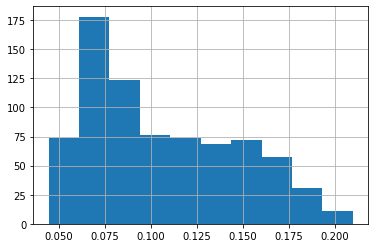

In [580]:
AgentsTimeSeries[AgentsTimeSeries['ratioCostForStaying'].notna()]['ratioCostForStaying'].hist()

In [581]:
AgentsTimeSeries['mortgage'] = 0
AgentsTimeSeries['rentPrice'] = 0

In [582]:
newAgents = AgentsTimeSeries.query("status.isnull() or status=='leave'", engine='python').copy()

In [583]:
newAgents.loc[newAgents.query("status.isnull()", engine='python').index,'group']='existing'

In [584]:
newAgents.loc[newAgents.query("status=='leave'", engine='python').index,'group']='add'

In [585]:
newAgents['yearsInBldg'] = 0

In [586]:
num = len(newAgents)
op = ageMiddle
p = ageDist

In [587]:
num

6067

In [588]:
ages = np.random.choice(op, size = num, p=p)

In [589]:
rent_own = np.random.choice(['rent','own'],size=num,p=[owners,1-owners])

In [590]:
rent_own

array(['rent', 'rent', 'rent', ..., 'rent', 'rent', 'rent'], dtype='<U4')

In [591]:
rent_filter = rent_own=='rent'
own_filter = rent_own=='own'

In [592]:
newAgents['age'] = ages

In [593]:
newAgents['age'] = newAgents['age'].apply(lambda x: np.random.randint(x-5,x+5)) # add varitation or noise ot ages

In [594]:
newAgents.loc[:,['lowDiscount','highDiscount','noDiscount']] = [0,0,1]

In [595]:
newAgents.loc[:,['rent','own']] = [0,0]

In [596]:
newAgents.loc[rent_filter,'rent'] =1
newAgents.loc[own_filter,'own'] =1

In [597]:
newAgents['agentID'] =newAgents['agentID'].apply(lambda x:uuid.uuid1()) 

In [598]:
newAgents['status'] = 'New Comers'

In [599]:
newAgents['reason_leave'] = np.nan

In [600]:
newAgents['HouseValue'] = 0
newAgents['rentPrint'] = 0
rentFilter = newAgents.query('rent==1').index
newAgents.loc[rentFilter,'rentPrice'] = rentPPM*newAgents.loc[rentFilter,'aprtmentSize'] 

ownFilter = newAgents.query('own==1').index
rentFilter = newAgents.query('rent==1').index
newAgents.loc[ownFilter,'HouseValue'] = newAgents.loc[ownFilter,'aprtmentSize'] * buyPPM
newAgents.loc[ownFilter,'mortgage'] = newAgents.loc[ownFilter,'HouseValue'].apply(lambda x: mortgageCal(houseValue=x,downPaymentPercent_range=(0.25, 0.26))).astype(int) 
newAgents['CostForStaying'] = newAgents['MainCost'] + newAgents['cityTax'] + newAgents['rentPrice'] + newAgents['mortgage']
newAgents['baseIncome'] = newAgents['CostForStaying']/0.38 # base is 38% for burden
newAgents['income'] = newAgents['baseIncome'] + newAgents['baseIncome'].apply(lambda x:np.random.randint(0,5000)).astype(int)


newAgents['ratioCostForStaying'] = (newAgents['CostForStaying']/newAgents['income'])

<AxesSubplot:>

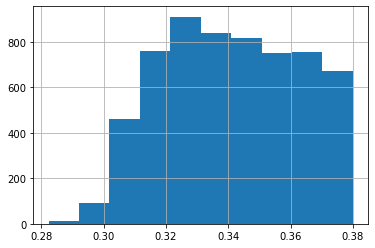

In [601]:
newAgents['ratioCostForStaying'].hist()

In [602]:
newAgents['ratioCostForStaying'].max()

0.37998377261887906

<AxesSubplot:>

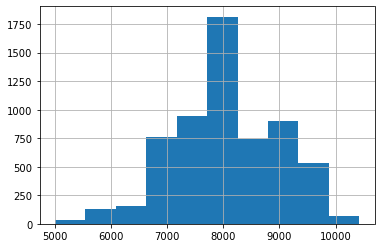

In [603]:
newAgents['CostForStaying'].hist()

In [604]:
newAgents_Merge = newAgents.query('group=="existing"').drop(columns=['HouseValue','rentPrint','baseIncome','group'])
newAgents_Add = newAgents.query('group=="add"').drop(columns=['HouseValue','rentPrint','baseIncome','group'])

In [605]:
newAgents_Merge.index

Int64Index([ 980,  981,  982,  983,  984,  985,  986,  987,  988,  989,
            ...
            7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233],
           dtype='int64', length=5332)

In [606]:
AgentsTimeSeries.loc[newAgents_Merge.index] = newAgents_Merge.copy() # Insert new Comers

In [607]:
AgentsTimeSeries = AgentsTimeSeries.append(newAgents_Add)
AgentsTimeSeries.reset_index(inplace=True, drop=True)

In [608]:
AgentsTimeSeries

,bldCode,doorIndex,bldCodeDoorIndex,ProjNumber,aprtmentSize,yearsInBldg,age,lowDiscount,highDiscount,noDiscount,income,rent,own,agentID,prjectType,tic,status,Floors,MainCost,cityTax,CostForStaying,ratioCostForStaying,reason_leave,mortgage,rentPrice
0,210_19,1,210_19_1,20180988,70,17.0,48.0,0.0,1.0,0.0,6375.000000,1.0,0.0,59325a1e-97d1-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,210_19,2,210_19_2,20180988,70,20.0,67.0,0.0,1.0,0.0,6163.000000,0.0,1.0,59325afa-97d1-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,210_19,3,210_19_3,20180988,70,9.0,42.0,0.0,1.0,0.0,5429.000000,0.0,1.0,59325b4a-97d1-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,210_19,4,210_19_4,20180988,70,5.0,42.0,0.0,0.0,1.0,15294.000000,0.0,1.0,59325b86-97d1-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,210_19,5,210_19_5,20180988,70,17.0,39.0,0.0,0.0,1.0,9742.000000,1.0,0.0,59325bb8-97d1-11eb-ab03-acde48001122,0,0,stay,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7964,201_75_rr,24,201_75_rr_24,502-0368860,112,0.0,47.0,0.0,0.0,1.0,24913.210526,1.0,0.0,fe67c064-9b82-11eb-a16b-acde48001122,3,32,New Comers,32.0,450.0,608.16,8898.16,0.357166,NaN,0,7840
7965,201_75_rr,25,201_75_rr_25,502-0368860,112,0.0,31.0,0.0,0.0,1.0,25145.210526,1.0,0.0,fe67c096-9b82-11eb-a16b-acde48001122,3,32,New Comers,32.0,450.0,608.16,8898.16,0.353871,NaN,0,7840
7966,201_75_rr,27,201_75_rr_27,502-0368860,112,0.0,33.0,0.0,0.0,1.0,25787.842105,0.0,1.0,fe67c0be-9b82-11eb-a16b-acde48001122,3,32,New Comers,32.0,450.0,608.16,9393.16,0.364248,NaN,8335,0
7967,201_75_rr,28,201_75_rr_28,502-0368860,112,0.0,26.0,0.0,0.0,1.0,26457.210526,1.0,0.0,fe67c0f0-9b82-11eb-a16b-acde48001122,3,32,New Comers,32.0,450.0,608.16,8898.16,0.336323,NaN,0,7840


## Now I need to:
1. create new agents for the displaced ones (and append them)
2. crearte new agents in general and place them in the same places.


# Generating new agents (All cases)
1. Israel Age Distribution
2. Mortgage Calculator for income
3. No Discount
4. Rent/Own random if Rent Income is lower
5. Status New Comers

In [609]:
newAgents[['bldCode','bldCodeDoorIndex','status']]

,bldCode,bldCodeDoorIndex,status
960,210_19_a,210_19_a_1,New Comers
961,210_19_a,210_19_a_2,New Comers
962,210_19_a,210_19_a_3,New Comers
964,210_19_a,210_19_a_5,New Comers
965,210_19_a,210_19_a_6,New Comers
...,...,...,...
7229,201_75_rr,201_75_rr_61,New Comers
7230,201_75_rr,201_75_rr_62,New Comers
7231,201_75_rr,201_75_rr_63,New Comers
7232,201_75_rr,201_75_rr_64,New Comers
